In [107]:
import numpy as np 
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import geopandas as gpd
from shapely.geometry import Point

In [108]:
#Read data
train_vals = pd.read_csv('../data/training_vals.csv')
train_labels = pd.read_csv('../data/training_labels.csv')
test_vals = pd.read_csv('../data/test_vals.csv')

#To make my train_test split easier later on: 
train_vals.set_index('id', inplace=True)
test_vals.set_index('id', inplace=True)
train_labels.set_index('id', inplace=True)

#For convenience
train_vals = train_vals.merge(train_labels, left_index=True, right_index=True)



###  Nulls / Faulty data

In [109]:
#Null values found in columns labeled False
train_vals.notnull().all().sort_values().head(10)

scheme_management        False
public_meeting           False
scheme_name              False
installer                False
subvillage               False
permit                   False
funder                   False
extraction_type           True
extraction_type_group     True
waterpoint_type           True
dtype: bool

 #### Scheme Management

In [110]:
train_vals.scheme_management.value_counts(dropna=False)

VWC                 36793
WUG                  5206
NaN                  3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [111]:
#Scheme management involves who operates the well. Safe to change NaN to "unknown"
train_vals.scheme_management.fillna(value="Unknown", inplace=True)

In [112]:
len(train_vals.subvillage.notnull())

59400

#### Permit, Public Meeting

In [113]:
train_vals.permit.value_counts(dropna=False)

True     38852
False    17492
NaN       3056
Name: permit, dtype: int64

In [114]:
train_vals.public_meeting.value_counts(dropna=False)

True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64

In [115]:
#Recode NaN to Unknown to end up with True/False/Unknown as only categories
train_vals.permit.fillna(value='Unknown', inplace=True)
train_vals.public_meeting.fillna(value='Unknown', inplace=True)

In [116]:
#Null values found in columns labeled False
train_vals.notnull().all().sort_values().head(10)

subvillage               False
installer                False
scheme_name              False
funder                   False
source_class              True
extraction_type           True
extraction_type_group     True
extraction_type_class     True
management                True
management_group          True
dtype: bool

#### Column Removal: First pass

Often, columns as specific as subvillage are accompanied by more general columns like region. I've chosen to use the more general columns to help the model best capture the trend in the data. 

Highly chaotic categorical features like installer and funder won't be used either, and the *name* of a scheme obviously has no predictive value. Note that scheme management was repaired for analysis a few cells earlier.

In [117]:
print("Number of unique subvillages: ", train_vals.subvillage.nunique())
print("Number of unique funders: ", train_vals.funder.nunique())
print("Number of unique installers: ", train_vals.installer.nunique())
print("Number of unique scheme names: ", train_vals.scheme_name.nunique())

Number of unique subvillages:  19287
Number of unique funders:  1897
Number of unique installers:  2145
Number of unique scheme names:  2696


In [118]:
#Get rid of a few columns: 
train_vals.drop(columns=['subvillage', 'installer', 'scheme_name', 'funder'], inplace=True)

In [119]:
#Sanity check: No more nulls? 
train_vals.notnull().all().all()

True

## EDA
Now that we have no more empty features, let's analyse the features themselves.

### Spatial Visualisation
Given the fact that we're trying to predict wether water wells are functional or not, it's a good idea to visually inspect the situation of the labeled wells before continuing. Perhaps location plays a role?

#### Cleaning / verifying coordinate columns

C:\Users\youri\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


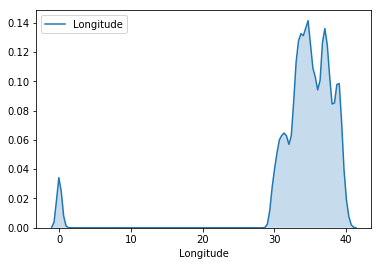

In [120]:
#Let's check if lat/lon are okay
#Longitude for Tanzania should be somewhere between 29 and 41
sns.kdeplot(data=train_vals['longitude'], legend=True, shade=True, label='Longitude')
plt.xlabel('Longitude')
None

In [121]:
#How many are wrong? 
len(train_vals[train_vals.longitude == 0])

1812

In [122]:
#Let's fix that: 
train_vals.longitude.replace(0, np.nan, inplace=True)

train_vals.longitude.fillna(train_vals.groupby(['region', 'district_code'])["longitude"].transform('mean'), inplace=True)
train_vals.longitude.fillna(train_vals.groupby(['region'])["longitude"].transform('mean'), inplace=True)

C:\Users\youri\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


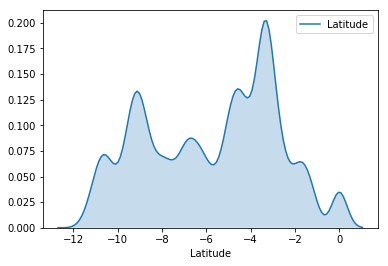

In [123]:
#Same deal for latitude
#Should be between -12 and 4 
sns.kdeplot(data=train_vals['latitude'], legend=True, shade=True, label='Latitude')
plt.xlabel('Latitude')
None

#### Setup

In [124]:
#Create geometry column and set up CRS
train_vals['Geometry'] = [Point(xy) for xy in zip(train_vals.longitude, train_vals.latitude)]

crs = {'init': 'epsg:4210'}

In [125]:
#Instantiate GeoDataFrame & load map
geo_train = gpd.GeoDataFrame(train_vals, crs=crs, geometry='Geometry')

tanzania_map = gpd.read_file('../data/Tanzania_regions_2014/Tanzania_regions_2014.shp')

#### Plotting

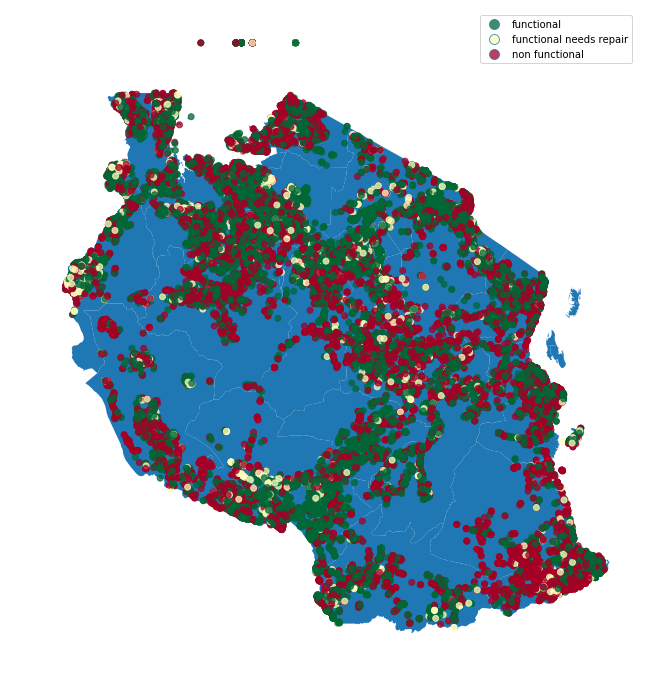

In [126]:
#Well, it certainly isn't a localized problem.
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'aspect': 'equal'})
tanzania_map.plot(ax=ax)
geo_train.plot(column='status_group', ax=ax, legend=True, cmap='RdYlGn_r', alpha=0.75)
ax.set_axis_off()
plt.savefig('../img/status_on_map.png')
None

### Label categories
What do our target labels actually look like? 

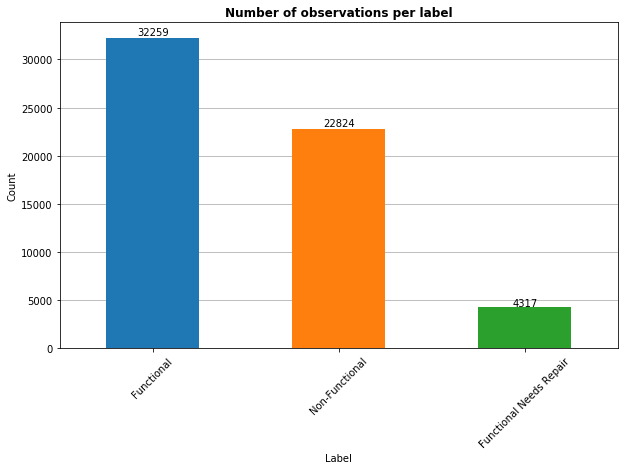

In [127]:
#Instantiate
fig, ax = plt.subplots(figsize=(10,6))
train_vals['status_group'].value_counts().plot.bar(ax=ax, rot=45)

#Prettify
ax.set_title('Number of observations per label', fontweight='bold')
ax.set_ylabel('Count')
ax.set_xlabel('Label')
ax.set_xticklabels(['Functional', 'Non-Functional', 'Functional Needs Repair'])
ax.yaxis.grid()
ax.set_axisbelow(True)

#Annotate
rects = ax.patches
for rect in rects:
    x=rect.get_x() + (rect.get_width()/2)
    y=rect.get_height() * 1.01
    ax.text(x, y, rect.get_height(), ha='center')
    
plt.savefig('../img/obs_per_label.png')


#### Water Amount: amount_tsh

C:\Users\youri\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


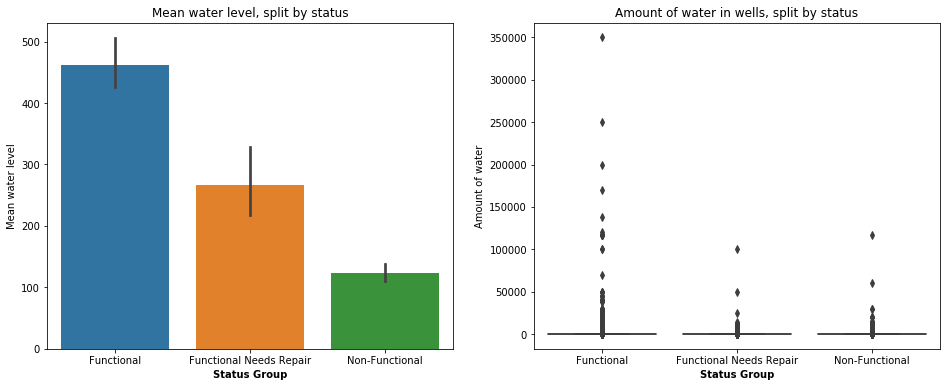

In [128]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))

#Barplot
sns.barplot(data=train_vals, y='amount_tsh', x='status_group', 
            order=['functional', 'functional needs repair', 'non functional'], ax=axes[0])
#Prettify
axes[0].set_title('Mean water level, split by status')
axes[0].set_ylabel('Mean water level')
axes[0].set_xlabel('Status Group', fontweight='bold')
axes[0].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

#Boxplot
sns.boxplot(data=train_vals, x='status_group', y='amount_tsh', order=['functional', 'functional needs repair', 'non functional'],
            ax=axes[1])
#Prettify
axes[1].set_title("Amount of water in wells, split by status")
axes[1].set_ylabel("Amount of water")
axes[1].set_xlabel("Status Group", fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

plt.savefig('../img/water_level_per_label.png')
None

While the barplot with grouped means looks great by itself, the boxplot (that isn't really a boxplot anymore) shows just how deceptive the means are, in this case. There's an overwhelming amount of zero-values in this feature. Let's investigate. 

In [129]:
#Note that the distribution looks really rather messed up
train_vals.groupby('status_group')['amount_tsh'].describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,461.798235,3889.735284,0.0,0.0,0.0,50.0,350000.0
functional needs repair,4317.0,267.071577,1925.026420,0.0,0.0,0.0,50.0,100000.0
non functional,22824.0,123.481230,1110.120571,0.0,0.0,0.0,0.0,117000.0


In [130]:
#Empty or unregistered Wells
print("Amount of empty or unregistered wells: ", len(train_vals[train_vals['amount_tsh'] == 0]))
print("Amount of non-empty wells: ", len(train_vals[train_vals['amount_tsh'] != 0]))

Amount of empty or unregistered wells:  41639
Amount of non-empty wells:  17761


In [131]:
#It seems highly likely that 0 was used as value for unmeasured water levels, along with those wells that actually
#did have no water. That said, with such an overwhelming amount of zeroes, I am not going to use this column at all.

#While we're at it, also using this field to remove the date the observation was recorded, since that's obviously irrelevant.
train_vals.drop(columns=['amount_tsh', 'date_recorded'], inplace=True)

#### Elevation of well: gps_height

C:\Users\youri\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


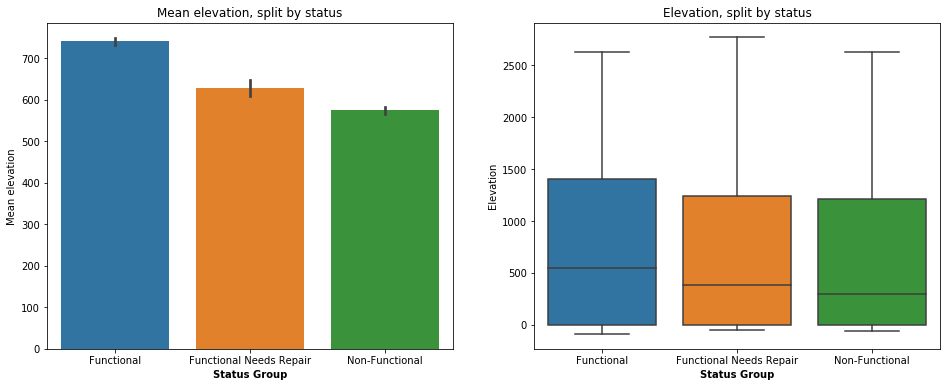

In [132]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))

#Barplot
sns.barplot(data=train_vals, y='gps_height', x='status_group', 
            order=['functional', 'functional needs repair', 'non functional'], ax=axes[0])
#Prettify
axes[0].set_title('Mean elevation, split by status')
axes[0].set_ylabel('Mean elevation')
axes[0].set_xlabel('Status Group', fontweight='bold')
axes[0].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

#Boxplot
sns.boxplot(data=train_vals, x='status_group', y='gps_height', order=['functional', 'functional needs repair', 'non functional'],
            ax=axes[1])
#Prettify
axes[1].set_title("Elevation, split by status")
axes[1].set_ylabel("Elevation")
axes[1].set_xlabel("Status Group", fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

plt.savefig('../img/elevation_per_label.png')

None

The means and distribution make this look like a feature that could well be used. Given the experience we've just had with amount_tsh, however, it's good to check if zero hasn't been treated as "null". Also, we should verify the elevations we see in the data.

In [133]:
#Instantiate
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'aspect': 'equal'})
tanzania_map.plot(ax=ax)
geo_train.plot(column='gps_height', ax=ax, cmap='RdYlGn_r', alpha=0.75)

#Prettify
ax.set_axis_off()
ax.set_title("Elevation of wells (m)", size=16)

#Manual colorbar, since GPD's built-in colorbar is far too big
from matplotlib.colors import Normalize
from matplotlib import cm
norm = Normalize(vmin=geo_train['gps_height'].min(), vmax=geo_train['gps_height'].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='RdYlGn_r')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap, shrink=0.75)

#Store
plt.savefig('../img/water_well_elevation.png')

plt.close()
None

<img  align=left src='https://i.pinimg.com/originals/92/c5/ae/92c5ae442f4ace1a84e97046e6d8b685.jpg' width=450/>
<img align=right src='../img/water_well_elevation.png' width=450/>


Map courtesy of [Maps of World](https://www.mapsofworld.com). 

This is a tricky one. It seems there are specific regions where the elevation of wells was not measured properly. The vast majority of the east of the country was logged properly - observed elevation matches the actual elevation very well. The yellow and red parts of the visualisation also match the actual map well; the mountain ranges and plateaus are easily recognizable. 

That said, we also can't miss the three to four enormous blocks of (near-) zero elevation where there should be an elevation of at least several hundred meters. 

In [134]:
#Well elevation
print("Amount of wells recorded with 0 elevation: ", len(train_vals[train_vals['gps_height'] == 0]))
print("Amount of wells with recorded elevation: ", len(train_vals[train_vals['gps_height'] != 0]))

Amount of wells recorded with 0 elevation:  20438
Amount of wells with recorded elevation:  38962


In [135]:
#Replace with nans to be able to use fillna
#As seen on the maps above, coastal areas in the east might have zero values that are completely valid.
#It's the three huge green spots that we need to deal with, not the coast near the indian ocean. 
train_vals.gps_height = np.where(train_vals.longitude < 38.1, train_vals.gps_height.replace(0, np.nan), train_vals.gps_height)

print("Amount of unregistered wells before imputation: ", train_vals.gps_height.isnull().sum())

Amount of unregistered wells before imputation:  20073


In [136]:
train_vals.gps_height.fillna(train_vals.groupby(['ward']).gps_height.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after ward imputation: ", train_vals.gps_height.isnull().sum())

Amount of unregistered wells after ward imputation:  18989


In [137]:
train_vals.gps_height.fillna(train_vals.groupby(['lga']).gps_height.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after lga imputation: ", train_vals.gps_height.isnull().sum())

Amount of unregistered wells after lga imputation:  8930


In [138]:
train_vals.gps_height.fillna(train_vals.groupby(['region']).gps_height.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after region imputation: ", train_vals.gps_height.isnull().sum())

Amount of unregistered wells after region imputation:  0


In [139]:
#New Map: 
temp_geo = gpd.GeoDataFrame(train_vals, crs=crs, geometry='Geometry')

#Instantiate
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'aspect': 'equal'})
tanzania_map.plot(ax=ax)
temp_geo.plot(column='gps_height', ax=ax, cmap='RdYlGn_r', alpha=0.75)

#Prettify
ax.set_axis_off()
ax.set_title("Elevation of wells (m)", size=16)

#Manual colorbar, since GPD's built-in colorbar is far too big
from matplotlib.colors import Normalize
from matplotlib import cm
norm = Normalize(vmin=temp_geo['gps_height'].min(), vmax=temp_geo['gps_height'].max())
n_cmap = cm.ScalarMappable(norm=norm, cmap='RdYlGn_r')
n_cmap.set_array([])
ax.get_figure().colorbar(n_cmap, shrink=0.75)

#Store
plt.savefig('../img/water_well_elevation_after_impute.png')

plt.close()
None

<img  align=left src='https://i.pinimg.com/originals/92/c5/ae/92c5ae442f4ace1a84e97046e6d8b685.jpg' width=450/>
<img align=right src='../img/water_well_elevation_after_impute.png' width=450/>


I will not pretend we have a perfect map at this rate, but the improvement over the elevation map pre-imputation is massive. The area around Lake Rukwa was filler in very nicely, as was the are near Lake Victoria and the area to its south. That said, I have some doubts about the quality of imputation around Dodoma. I fear our data slightly underestimates the elevation there, but it's certainly close enough to be workable. 

In [140]:
#Remove cols
#Further removal is just a name column and an empty one that obviously have no predictive value.
train_vals.drop(columns=['wpt_name', 'num_private'], inplace=True)

### Region / location features

We have a large number of different features that all amount to the same thing: a location feature. While it seems likely that location has an effect on water well funtionality, we should check first. 

Note that Tanzania has 31 regions, but we do not expect all of them to appear in our data. Earlier spatial visualization (found above) indicated that, for example, the islands to the east of the country did not show water wells featured in the data.

We also have a more general feature, basins, with fewer categories. We'll dive into both.

#### Basin vs Region

In [141]:
#Basin
basin_pivot = train_vals.pivot_table(values='public_meeting', index='basin', columns='status_group', aggfunc='count')
basin_pivot['total'] = basin_pivot['functional'] + basin_pivot['functional needs repair'] + basin_pivot['non functional']
for col in basin_pivot.columns: 
    basin_pivot[col] = basin_pivot[col] / basin_pivot['total'] * 100
    
#Region
region_pivot = train_vals.pivot_table(values='public_meeting', index='region', columns='status_group', aggfunc='count')
region_pivot['total'] = region_pivot['functional'] + region_pivot['functional needs repair'] + region_pivot['non functional']
for col in region_pivot.columns: 
    region_pivot[col] = region_pivot[col] / region_pivot['total'] * 100

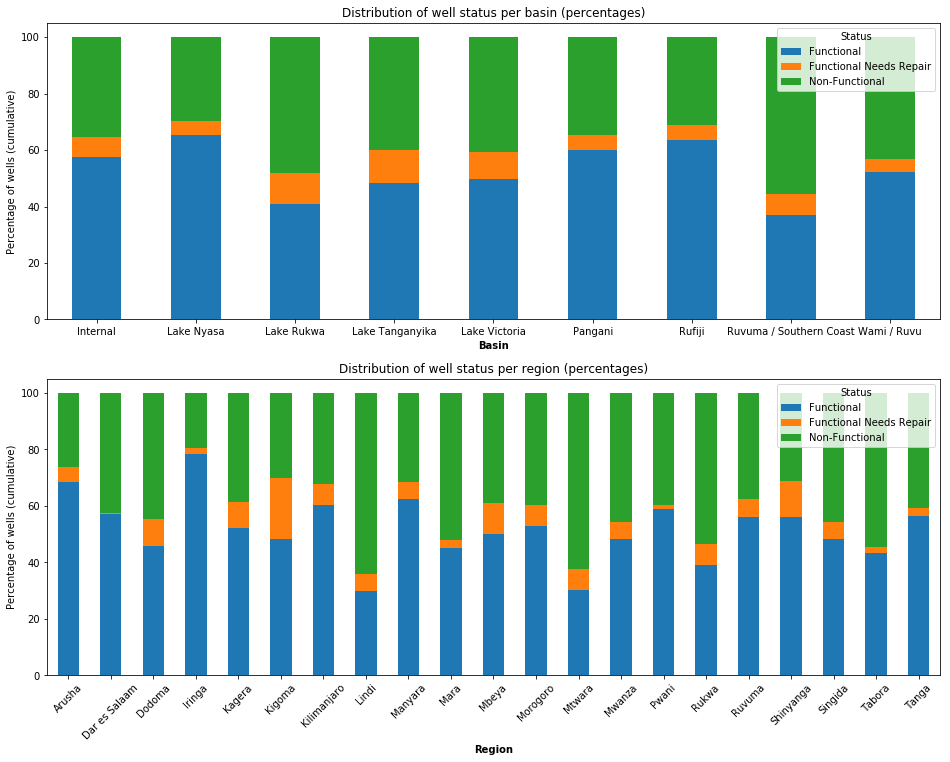

In [142]:
#Instantiate
fig, axes = plt.subplots(2, 1, figsize=(16,12))
basin_pivot.iloc[:, :3].plot.bar(stacked=True, ax=axes[0], rot=360)
region_pivot.iloc[:, :3].plot.bar(stacked=True, ax=axes[1], rot=45)

#Prettify Basin
axes[0].set_title('Distribution of well status per basin (percentages)')
axes[0].set_ylabel('Percentage of wells (cumulative)')
axes[0].set_xlabel('Basin', fontweight='bold')
axes[0].legend(title='Status', labels=['Functional', 'Functional Needs Repair', 'Non-Functional'])


#Prettify region
axes[1].set_title('Distribution of well status per region (percentages)')
axes[1].set_ylabel('Percentage of wells (cumulative)')
axes[1].set_xlabel('Region', fontweight='bold')
axes[1].legend(title='Status', labels=['Functional', 'Functional Needs Repair', 'Non-Functional'])

plt.savefig('../img/label_per_location.png')

None

The differences between status (of wells) between regions is, as expected, an exaggerated version of the differences between basins. That said, the "functional needs repair" label varies little when looking at basins, while it knows large variations on a region-level. 

It's good to see variations occur when location is inspected more specifically. There will obviously be a lot of overlap between region columns, but it does seem like one doesn't necessarily make the other obsolete. 

In [143]:
#Check for typos
train_vals.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [144]:
#Note that region code doesn't match region, so we'll just encode region ourselves and get rid of this one.
train_vals.region_code.value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

### Population
Note that this involves just the local population around the well itself.

In [145]:
#Continuous variable, so an ECDF might be helpful:
def ecdf(col): 
    x=np.sort(col)
    y=np.arange(1, len(x)+1) / len(x)
    return x,y
x_pop, y_pop = ecdf(train_vals.population)


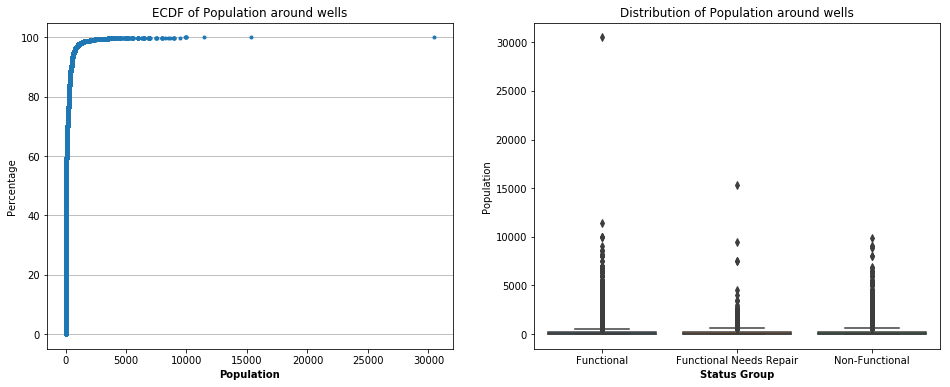

In [146]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(x_pop, y_pop, marker='.', linestyle='none')
sns.boxplot(data=train_vals, x='status_group', y='population', order=['functional', 'functional needs repair', 'non functional'],
            ax=axes[1])
#Prettify
axes[0].set_xlabel('Population', fontweight='bold')
axes[0].set_yticklabels([0, 0, 20, 40, 60, 80, 100])
axes[0].set_ylabel('Percentage')
axes[0].set_title('ECDF of Population around wells')
axes[0].yaxis.grid()

axes[1].set_xlabel('Status Group', fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])
axes[1].set_ylabel('Population')
axes[1].set_title('Distribution of Population around wells')

plt.savefig('../img/population_distribution.png')

None

In [147]:
#Quantitative version
train_vals.groupby('status_group').population.describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,187.553303,513.198991,0.0,0.0,40.0,200.0,30500.0
functional needs repair,4317.0,175.102154,433.033756,0.0,0.0,25.0,245.0,15300.0
non functional,22824.0,170.016430,413.094978,0.0,0.0,1.0,230.0,9865.0


In [148]:
#Uninhabited wells or wells with unregistered population
print("Amount of uninhabited or unregistered wells: ", len(train_vals[train_vals['population'] == 0]))
print("Amount of inhabited or registered wells: ", len(train_vals[train_vals['population'] != 0]))

Amount of uninhabited or unregistered wells:  21381
Amount of inhabited or registered wells:  38019


The picture here is pretty much the same as that of *amount_tsh* or *gps_height*. Missing values have obviously been encoded as 0, which distorts the entire feature. 

I can't help but think population would be an important feature if it were complete. It makes sense for wells that are highly busy to break or deplete earlier. It also makes sense that wells in highly populated areas would get marked as *needs repair* earlier, since they would theoretically be checked way more often.

In [149]:
#Replace with nans to be able to use fillna
train_vals.population.replace(0, np.nan, inplace=True)
print("Amount of unregistered wells before any imputation: ", train_vals.population.isnull().sum())

Amount of unregistered wells before any imputation:  21381


In [150]:
train_vals.population.fillna(train_vals.groupby(['ward', 'status_group']).population.transform('mean').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after ward imputation: ", train_vals.population.isnull().sum())

Amount of unregistered wells after ward imputation:  19872


In [151]:
train_vals.population.fillna(train_vals.groupby(['lga', 'status_group']).population.transform('mean').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after lga imputation: ", train_vals.population.isnull().sum())

Amount of unregistered wells after lga imputation:  10765


In [152]:
train_vals.population.fillna(train_vals.groupby(['region', 'status_group']).population.transform('mean').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after region imputation: ", train_vals.population.isnull().sum())

Amount of unregistered wells after region imputation:  1634


In [153]:
train_vals.population.fillna(train_vals.groupby(['basin', 'status_group']).population.transform('mean').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after basin imputation: ", train_vals.population.isnull().sum())

Amount of unregistered wells after basin imputation:  0


In [154]:
#Back to ints
train_vals.population = train_vals.population.astype(int)

In [155]:
#Remove recorded_by, which only contains 1 value
train_vals.drop(columns=['recorded_by'], inplace=True)

### Construction year

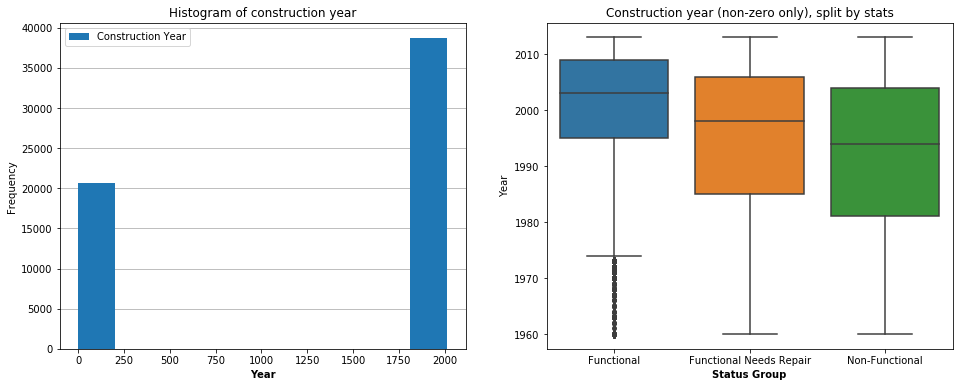

In [156]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].hist(train_vals['construction_year'], label='Construction Year')
sns.boxplot(data=train_vals[train_vals['construction_year'] != 0], x='status_group', y='construction_year',
            order=['functional', 'functional needs repair', 'non functional'])
#Prettify
axes[0].legend()
axes[0].set_xlabel('Year', fontweight='bold')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of construction year')
axes[0].yaxis.grid()
axes[0].set_axisbelow(True)

#Prettify
axes[1].set_title("Construction year (non-zero only), split by stats")
axes[1].set_ylabel("Year")
axes[1].set_xlabel("Status Group", fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

plt.savefig('../img/construction_year_pre_impute.png')
None

In [157]:
#Quantitative
train_vals[train_vals['construction_year'] != 0].groupby('status_group').construction_year.describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,21704.0,1999.938675,10.931700,1960.0,1995.0,2003.0,2009.0,2013.0
functional needs repair,2528.0,1995.257911,12.533262,1960.0,1985.0,1998.0,2006.0,2013.0
non functional,14459.0,1992.397538,13.222473,1960.0,1981.0,1994.0,2004.0,2013.0


In [158]:
#Wells with unregistered construction year
print("Amount of unregistered wells: ", len(train_vals[train_vals['construction_year'] == 0]))
print("Amount of properly registered wells: ", len(train_vals[train_vals['construction_year'] != 0]))

Amount of unregistered wells:  20709
Amount of properly registered wells:  38691


The story here is, again, pretty much the same as with almost all other quantitative features we've seen. That said, on a theoretical level it would seem that the age of a water well is one of the, if not the most important feature determining the functionality of said well. Therefore, I *really* don't want to be forced to lose this feature. 

Since there are so many missing values, I wouldn't want to be overly rough with imputation. Therefore, I'm going to grab the non-zero means of construction year per status group (like in the boxplot above), and use that to fill in construction year where it is currently recorded as zero. I'm going to use location as specifically as possible, so I'll start with the ward/status combination, and work my way back up to the basin/status combination. 

In [159]:
#Okay, from most to least specific:
print("Number of unique wards: ", train_vals.ward.nunique())
print("Number of unique districts: ", train_vals.lga.nunique())
print("Number of unique regions: ", train_vals.region.nunique())
print("Number of unique basins: ", train_vals.basin.nunique())

Number of unique wards:  2092
Number of unique districts:  125
Number of unique regions:  21
Number of unique basins:  9


First I'll impute based on ward (the most local form), then on lga, then region, and then basin. That way, all values get filled in with the most specific value present in the dataset. 

In [160]:
#Replace with nans to be able to use fillna
train_vals.construction_year.replace(0, np.nan, inplace=True)

In [161]:
train_vals.construction_year.fillna(train_vals.groupby(['ward', 'status_group']).construction_year.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after ward imputation: ", train_vals.construction_year.isnull().sum())

Amount of unregistered wells after ward imputation:  18996


In [162]:
train_vals.construction_year.fillna(train_vals.groupby(['lga', 'status_group']).construction_year.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after lga imputation: ", train_vals.construction_year.isnull().sum())

Amount of unregistered wells after lga imputation:  10126


In [163]:
train_vals.construction_year.fillna(train_vals.groupby(['region', 'status_group']).construction_year.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after region imputation: ", train_vals.construction_year.isnull().sum())

Amount of unregistered wells after region imputation:  1634


In [164]:
train_vals.construction_year.fillna(train_vals.groupby(['basin', 'status_group']).construction_year.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after basin imputation: ", train_vals.construction_year.isnull().sum())

Amount of unregistered wells after basin imputation:  0


In [165]:
#Back to ints
train_vals.construction_year = train_vals.construction_year.astype(int)

#### Re-evaluate construction year
Now that all values have been imputed, let's re-evaluate the feature. 

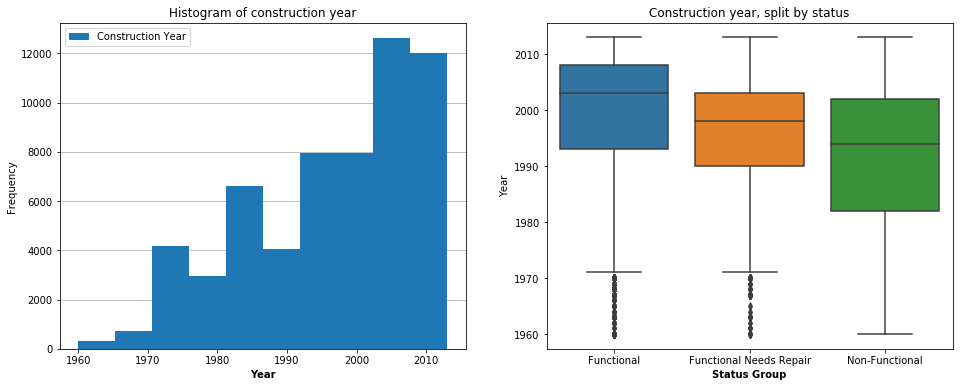

In [166]:
#Instantiate
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].hist(train_vals['construction_year'], label='Construction Year')
sns.boxplot(data=train_vals, x='status_group', y='construction_year',
            order=['functional', 'functional needs repair', 'non functional'])
#Prettify
axes[0].legend()
axes[0].set_xlabel('Year', fontweight='bold')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of construction year')
axes[0].yaxis.grid()
axes[0].set_axisbelow(True)

#Prettify
axes[1].set_title("Construction year, split by status")
axes[1].set_ylabel("Year")
axes[1].set_xlabel("Status Group", fontweight='bold')
axes[1].set_xticklabels(['Functional', 'Functional Needs Repair', 'Non-Functional'])

plt.savefig('../img/construction_year_post_impute.png')

None

In [167]:
#Quantitative
train_vals.groupby('status_group').construction_year.describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,1999.697666,10.576574,1960.0,1993.0,2003.0,2008.0,2013.0
functional needs repair,4317.0,1995.800788,10.242888,1960.0,1990.0,1998.0,2003.0,2013.0
non functional,22824.0,1991.741807,12.561641,1960.0,1982.0,1994.0,2002.0,2013.0


In [168]:
#Now that we're done imputing, we can drop the non-region location columns. 
#Note that I specified earlier that region would be the location column to keep as feature. I just used the rest for imputation.
train_vals.drop(columns=['region_code', 'district_code', 'ward'], inplace=True)

### Feature Selection
A large number of features has already been evaluated and filtered above. That said, there are quite a few more features, that mostly follow the same pattern, where a feature is repeated several times, varying in detail. I'm going to consistently pick the version of the feature that has most detail, to avoid losing any information unnecessarily


In [169]:
featurelist = ['longitude', 'latitude', 'gps_height', 'region', 'basin', 'lga', 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'population']

In [170]:
#Exctraction
print("Type: ", train_vals.extraction_type.nunique())
print("Type group: ", train_vals.extraction_type_group.nunique())
print("Type class: ", train_vals.extraction_type_class.nunique())

Type:  18
Type group:  13
Type class:  7


In [171]:
featurelist.append('extraction_type')

In [172]:
#Management
print("Management: ", train_vals.management.nunique())
print("Management Group: ", train_vals.management_group.nunique())

Management:  12
Management Group:  5


In [173]:
featurelist.append('management')

In [174]:
#Payment
print("Payment: ", train_vals.payment.nunique())
print("Payment Type: ", train_vals.payment_type.nunique())

Payment:  7
Payment Type:  7


In [175]:
#What's going on?
train_vals.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [176]:
#Ah, they're completely identical
train_vals.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [177]:
#I'll go with payment_type cause it's formatted a little nicer
featurelist.append('payment_type')

In [178]:
#Water quality
print("Quality: ", train_vals.water_quality.nunique())
print("Quality group: ", train_vals.quality_group.nunique())

Quality:  8
Quality group:  6


In [179]:
featurelist.append('water_quality')

In [180]:
#Water quantity
print("Quantity: ", train_vals.quantity.nunique())
print("Quantity group: ", train_vals.quantity_group.nunique())

Quantity:  5
Quantity group:  5


In [181]:
#What's going on?
train_vals.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [182]:
#100% identical
train_vals.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [183]:
featurelist.append('quantity')

In [184]:
#Source
print("Source: ", train_vals.source.nunique())
print("Type: ", train_vals.source_type.nunique())
print("Class: ", train_vals.source_class.nunique())

Source:  10
Type:  7
Class:  3


In [185]:
featurelist.append('source')

In [186]:
#Waterpoint type
print("Type: ", train_vals.waterpoint_type.nunique())
print("Group: ", train_vals.waterpoint_type_group.nunique())

Type:  7
Group:  6


In [187]:
featurelist.append('waterpoint_type')

In [188]:
#Let's not forget status group itself
featurelist.append('status_group')

#### Wrap up 

In [189]:
#What did we end up with?
featurelist

['longitude',
 'latitude',
 'gps_height',
 'region',
 'basin',
 'lga',
 'public_meeting',
 'scheme_management',
 'permit',
 'construction_year',
 'population',
 'extraction_type',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'status_group']

In [190]:
#Subset
train_vals = train_vals[featurelist]

In [191]:
#Store for ML
train_vals.to_csv('../data/edited_train_set.csv')

## Test Set
For the test set, we obviously don't have status_group to work with like I have done many, many times above. That said, we still need to prepare that set for analysis the same way we did with the training values. Below, I'll ensure we use the same features, and remove null values where needed. In the cases where imputation was performed in the training set, it will be carried out in the test set as well, but in a slightly more crude manner, since status group will not be taken into consideration. 

In [192]:
#Do we have nulls?
test_vals[featurelist[:-1]].notnull().all()

longitude             True
latitude              True
gps_height            True
region                True
basin                 True
lga                   True
public_meeting       False
scheme_management    False
permit               False
construction_year     True
population            True
extraction_type       True
management            True
payment_type          True
water_quality         True
quantity              True
source                True
waterpoint_type       True
dtype: bool

In [193]:
#Fill in NaN in categorical columns that have NaNs
test_vals.scheme_management.fillna(value="Unknown", inplace=True)
test_vals.permit.fillna(value='Unknown', inplace=True)
test_vals.public_meeting.fillna(value='Unknown', inplace=True)

#### GPS Height

In [194]:
#Replace with nans to be able to use fillna
#As seen on the maps above, coastal areas in the east might have zero values that are completely valid.
#It's the three huge green spots that we need to deal with, not the coast near the indian ocean. 
test_vals.gps_height = np.where(test_vals.longitude < 38.1, test_vals.gps_height.replace(0, np.nan), test_vals.gps_height)

print("Amount of unregistered wells before imputation: ", test_vals.gps_height.isnull().sum())

Amount of unregistered wells before imputation:  5127


In [196]:
test_vals.gps_height.fillna(test_vals.groupby(['ward']).gps_height.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after ward imputation: ", test_vals.gps_height.isnull().sum())

Amount of unregistered wells after ward imputation:  4899


In [197]:
test_vals.gps_height.fillna(test_vals.groupby(['lga']).gps_height.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after lga imputation: ", test_vals.gps_height.isnull().sum())

Amount of unregistered wells after lga imputation:  2563


In [198]:
test_vals.gps_height.fillna(test_vals.groupby(['region']).gps_height.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after region imputation: ", test_vals.gps_height.isnull().sum())

Amount of unregistered wells after region imputation:  0


#### Population

In [199]:
#Replace with nans to be able to use fillna
test_vals.population.replace(0, np.nan, inplace=True)
print("Amount of unregistered wells before imputation: ", test_vals.population.isnull().sum())

Amount of unregistered wells before imputation:  5453


In [200]:
test_vals.population.fillna(test_vals.groupby(['ward']).population.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after ward imputation: ", test_vals.population.isnull().sum())

Amount of unregistered wells after ward imputation:  5065


In [201]:
test_vals.population.fillna(test_vals.groupby(['lga']).population.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after lga imputation: ", test_vals.population.isnull().sum())

Amount of unregistered wells after lga imputation:  2672


In [202]:
test_vals.population.fillna(test_vals.groupby(['region']).population.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after region imputation: ", test_vals.population.isnull().sum())

Amount of unregistered wells after region imputation:  0


In [203]:
#Back to ints
test_vals.construction_year = test_vals.construction_year.astype(int)

#### Construction year

In [204]:
#Replace with nans to be able to use fillna
test_vals.construction_year.replace(0, np.nan, inplace=True)
print("Amount of unregistered wells before imputation: ", test_vals.construction_year.isnull().sum())

Amount of unregistered wells before imputation:  5260


In [205]:
test_vals.construction_year.fillna(test_vals.groupby(['ward']).construction_year.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after ward imputation: ", test_vals.construction_year.isnull().sum())

Amount of unregistered wells after ward imputation:  4868


In [206]:
test_vals.construction_year.fillna(test_vals.groupby(['lga']).construction_year.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after lga imputation: ", test_vals.construction_year.isnull().sum())

Amount of unregistered wells after lga imputation:  2513


In [207]:
test_vals.construction_year.fillna(test_vals.groupby(['region']).construction_year.transform('median').round(),
                                    inplace=True)

#Wells with unregistered construction year
print("Amount of unregistered wells after region imputation: ", test_vals.construction_year.isnull().sum())

Amount of unregistered wells after region imputation:  0


In [208]:
#Back to ints
test_vals.construction_year = test_vals.construction_year.astype(int)

In [209]:
#Subset
test_vals = test_vals[featurelist[:-1]]

In [210]:
#Store
test_vals.to_csv('../data/edited_test_set.csv')